In [ ]:
!wget http://www.eecs.yorku.ca/~bil/Datasets/for-rerec.tar.gz

--2021-12-02 12:44:43--  http://www.eecs.yorku.ca/~bil/Datasets/for-rerec.tar.gz
Resolving www.eecs.yorku.ca (www.eecs.yorku.ca)... 130.63.94.24
Connecting to www.eecs.yorku.ca (www.eecs.yorku.ca)|130.63.94.24|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eecs.yorku.ca/~bil/Datasets/for-rerec.tar.gz [following]
--2021-12-02 12:44:43--  https://www.eecs.yorku.ca/~bil/Datasets/for-rerec.tar.gz
Connecting to www.eecs.yorku.ca (www.eecs.yorku.ca)|130.63.94.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1633453504 (1.5G) [application/x-tar]
Saving to: ‘for-rerec.tar.gz’

for-rerec.tar.gz    100%[===================>]   1.52G  17.0MB/s    in 95s     

2021-12-02 12:46:19 (16.4 MB/s) - ‘for-rerec.tar.gz’ saved [1633453504/1633453504]



In [ ]:
!tar -xvf for-rerec.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
for-rerecorded/training/fake/recording2061.wav_norm_mono.wav
for-rerecorded/training/fake/recording2062.wav_norm_mono.wav
for-rerecorded/training/fake/recording2063.wav_norm_mono.wav
for-rerecorded/training/fake/recording2064.wav_norm_mono.wav
for-rerecorded/training/fake/recording2065.wav_norm_mono.wav
for-rerecorded/training/fake/recording2066.wav_norm_mono.wav
for-rerecorded/training/fake/recording2069.wav_norm_mono.wav
for-rerecorded/training/fake/recording2070.wav_norm_mono.wav
for-rerecorded/training/fake/recording2072.wav_norm_mono.wav
for-rerecorded/training/fake/recording2073.wav_norm_mono.wav
for-rerecorded/training/fake/recording2074.wav_norm_mono.wav
for-rerecorded/training/fake/recording2075.wav_norm_mono.wav
for-rerecorded/training/fake/recording2076.wav_norm_mono.wav
for-rerecorded/training/fake/recording2077.wav_norm_mono.wav
for-rerecorded/training/fake/recording2079.wav_norm_mono.wav
for-rerecorded/tr

In [ ]:
import os
import requests

import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T


In [ ]:
def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(path, resample=None):
  return _get_sample(path, resample=resample)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

Shape: (1, 513, 57)
Dtype: torch.float32
 - Max:     76439.695
 - Min:      0.000
 - Mean:    57.345
 - Std Dev: 1242.300

tensor([[[8.7133e+00, 5.2486e+01, 1.9363e+01,  ..., 1.0175e+01,
          7.4003e+00, 1.0113e+02],
         [1.7838e-03, 1.3306e+01, 1.1958e+01,  ..., 1.3854e+01,
          2.4504e+00, 8.9536e+01],
         [1.3959e+01, 3.2044e+00, 1.3500e+00,  ..., 6.8815e+00,
          5.0279e-01, 4.5564e+01],
         ...,
         [3.2592e-04, 9.2967e-03, 1.8641e-05,  ..., 1.8474e-13,
          1.8955e-13, 1.7210e-08],
         [1.0786e-02, 9.0586e-03, 5.8639e-08,  ..., 5.1514e-13,
          4.6185e-13, 1.7122e-08],
         [2.3039e-02, 4.2362e-03, 2.7989e-06,  ..., 5.6843e-14,
          2.2737e-13, 1.7070e-08]]])



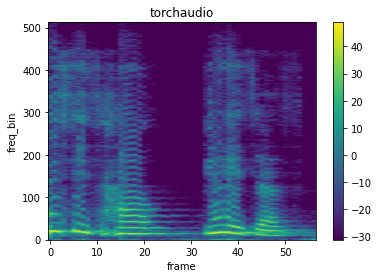

In [ ]:
waveform, sample_rate = get_speech_sample('/content/for-rerecorded/training/real/recording10000.wav_norm_mono.wav')

n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(waveform)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')

In [ ]:
import math, random
import torch
import numpy as np
import torchaudio
from IPython.display import Audio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = T.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = T.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    mel = T.MelSpectrogram(
        sr,
        n_fft=n_fft,
        hop_length=hop_len,
        n_mels=n_mels,
    )(sig)

    mfcc = T.MFCC(
        sr,
        n_mfcc=n_mels,
        melkwargs={
          'n_fft': n_fft,
          'n_mels': n_mels,
          'hop_length': hop_len,
        }
    )(sig)
    mel = T.AmplitudeToDB(top_db=top_db)(mel)
    mfcc = T.AmplitudeToDB(top_db=top_db)(mfcc)
    spec = torch.cat((mel, mfcc), dim=0)
    # Convert to decibels
    return (spec)

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class VoiceSet(Dataset):
  def __init__(self, voice_df, size=256, channels=1):
    super().__init__()
    self.df = voice_df
    self.size = size
    self.channels = channels
    self.duration = 2000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    path, label = self.df.iloc[index]
    aud = AudioUtil.open(path)
    reaud = AudioUtil.resample(aud, self.sr)
    dur_aud = AudioUtil.pad_trunc(reaud, self.duration)
    sgram = AudioUtil.spectro_gram(dur_aud, n_mels=224, n_fft=1024, hop_len=None)
    return (sgram, 1 if label == 'fake' else 0)

In [ ]:
import pandas as pd

data = []
sample = 'training'
for file in os.listdir(f'for-rerecorded/{sample}/real'):
  data.append((f'for-rerecorded/{sample}/real/{file}', 'real'))
for file in os.listdir(f'for-rerecorded/{sample}/fake'):
  data.append((f'for-rerecorded/{sample}/fake/{file}', 'fake'))
df = pd.DataFrame(data, columns=['path', 'label'])
df = df.sample(frac=1).reset_index(drop=True)
train_dataset = VoiceSet(df)

data = []
sample = 'validation'
for file in os.listdir(f'for-rerecorded/{sample}/real'):
  data.append((f'for-rerecorded/{sample}/real/{file}', 'real'))
for file in os.listdir(f'for-rerecorded/{sample}/fake'):
  data.append((f'for-rerecorded/{sample}/fake/{file}', 'fake'))
df = pd.DataFrame(data, columns=['path', 'label'])
df = df.sample(frac=1).reset_index(drop=True)
val_dataset = VoiceSet(df)

In [ ]:
len(train_dataset), len(val_dataset)

(10208, 2244)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=4)
dataloaders = {'train': train_dataloader, 'valid': val_dataloader}
datasets = {'train': train_dataset, 'valid': val_dataset}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# TRAIN
import time
import copy
from tqdm import tqdm_notebook
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            running_total = 0.0
            
            for step, (inputs, labels) in tqdm_notebook(enumerate(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
               
                # Zero out the grads
                optimizer.zero_grad()
                
                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_total += len(labels.data)
                
                if (step + 1) % 100 == 0:
                    print(f'[{step + 1}/{len(dataloaders[phase])}].')
                    print(f'Loss {running_loss / running_total}. Accuracy {running_corrects / running_total}')
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model

In [ ]:
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

class AudioVGG16 (nn.Module):

    def __init__(self):
        super().__init__()
        self.blocks = []
        self.blocks.append(nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 64,kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        ))

        # Second Convolution Block
        self.blocks.append(nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        ))
        
        self.blocks.append(nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        ))

        self.blocks.append(nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        ))

        self.blocks.append(nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.BatchNorm2d(512)
        ))
        self.blocks.append(nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 2),

        ))
        self.model = nn.Sequential(*self.blocks)
 
    def forward(self, x):
        x = self.model(x)
        return x


In [ ]:
import torchvision.models as models
from torchaudio.models import ConvTasNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioVGG16()
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

criterion = nn.CrossEntropyLoss()
num_epochs = 3

In [ ]:
trained_model = train_model(datasets, dataloaders,
                            model, criterion,
                            optimizer, scheduler,
                            num_epochs, device)

Epoch 0/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At leas

[100/638].
Loss 0.059034164757467804. Accuracy 0.984375
[200/638].
Loss 0.0702435015887022. Accuracy 0.9784374833106995
[300/638].
Loss 0.07359223879097651. Accuracy 0.9777083396911621
[400/638].
Loss 0.07302448423230089. Accuracy 0.9779687523841858
[500/638].
Loss 0.06952713371021674. Accuracy 0.9785000681877136
[600/638].
Loss 0.06657219485379756. Accuracy 0.9800000190734863
train Loss: 0.0656 Acc: 0.9802


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At leas

[100/141].
Loss 0.08755970356753096. Accuracy 0.9668749570846558
valid Loss: 0.0904 Acc: 0.9666

Epoch 1/2
----------


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At leas

[100/638].
Loss 0.04657717254711315. Accuracy 0.9868749976158142
[200/638].
Loss 0.053651850273599845. Accuracy 0.9831249713897705
[300/638].
Loss 0.057244383038487286. Accuracy 0.9831250309944153
[400/638].
Loss 0.056730218174052424. Accuracy 0.9829687476158142
[500/638].
Loss 0.05288908798014745. Accuracy 0.9842500686645508
[600/638].
Loss 0.05024373096995987. Accuracy 0.9847916960716248
train Loss: 0.0497 Acc: 0.9851


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At leas

[100/141].
Loss 0.08058302496792749. Accuracy 0.9724999666213989
valid Loss: 0.0848 Acc: 0.9719

Epoch 2/2
----------


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At leas

[100/638].
Loss 0.0479400289664045. Accuracy 0.984375
[200/638].
Loss 0.05156233947258443. Accuracy 0.9853124618530273
[300/638].
Loss 0.0519281464170975. Accuracy 0.9850000143051147
[400/638].
Loss 0.05156131014460698. Accuracy 0.98499995470047
[500/638].
Loss 0.04782315015187487. Accuracy 0.9860000610351562
[600/638].
Loss 0.0453260699857492. Accuracy 0.9871875047683716
train Loss: 0.0453 Acc: 0.9871


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At leas

[100/141].
Loss 0.07637062322115526. Accuracy 0.9756249785423279
valid Loss: 0.0831 Acc: 0.9715

Training complete in 31m 46s
Best val Acc: 0.9719
